# MNIST Analysis

In [1]:
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import torch
from utils_dataset import ToCurrent, load_MNIST, set_random_seed, get_fft, extract_interval
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

seed = 42
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
generator = set_random_seed(seed, add_generator=True, device=device)
shuffle_data = False

folder = Path('dataset_analysis')
folder_run = Path(os.path.join(folder,'MNIST'))
folder_fig = folder_run.joinpath('fig')
folder_data = folder_run.joinpath('data')
folder_fig.mkdir(parents=True, exist_ok=True)
folder_data.mkdir(parents=True, exist_ok=True)

In [2]:
import torch
import torch.nn as nn
import argparse
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange
import seaborn as sns
import numpy as np
from datasets import load_data
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from numpy.fft import rfft, rfftfreq
import tqdm
import os
from scipy import signal
import json
from torchvision.datasets import MNIST

firing_mode_dict = {
    "FA": {"a": 5, "A1": 0, "A2": 0},
    "SA": {"a": 0, "A1": 0, "A2": 0},
    "MIX": {"a": 5, "A1": 5, "A2": -0.3},
}

g = torch.Generator()

# def classifier(train_dl, test_dl, epochs=None, batch_size=100, generator=None):

#     print(f'Len test set {len(test_dl)}')
    
#     classifier = nn.Sequential(
#         nn.Linear(data.shape[1], len(np.unique(labels))),
#     ).to(device)
#     optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
#     if epochs is None:
#         epochs = trange(100, desc=f"Classifier")
#     else:
#         epochs.reset()
#     batches = tqdm.tqdm(train_dl, desc="Epoch", disable=True)
#     loss = nn.CrossEntropyLoss()
#     loss_coll = []
#     acc_coll = []
    
#     list_acc_last_epoch = []
#     n_epochs = 100
#     for epoch in range(n_epochs):
#         loss_list = []
#         acc_list = []
#         batches.reset()
#         batches.set_description('Training')
        
#         for batch_idx, (data, target) in enumerate(train_dl):
#             data = data.float()
#             target = target.long()
#             out = classifier(data)
#             loss_val = loss(out, target)
#             loss_val.backward()
#             optimizer.step()
#             optimizer.zero_grad()
#             loss_list.append(loss_val.item())
#             batches.update()
            
#         batches.reset(total=len(test_dl))
#         batches.set_description('Testing')
        
#         with torch.no_grad():
#             for batch_idx, (data, target) in enumerate(test_dl):
#                 data = data.float()
#                 target = target.long()
#                 out = classifier(data)
                
#                 acc = torch.mean((torch.argmax(out, dim=1) == target).to(torch.int16), dtype=torch.float)
#                 acc_list.append(acc.item())
#                 if epoch == (n_epochs-1):
#                     list_acc_last_epoch.append(acc.tolist())
#                 batches.update()
                
#         loss_coll.append(np.mean(loss_list))
#         acc_coll.append(np.mean(acc_list))
#         epochs.set_postfix_str(f"Loss: {np.mean(loss_list):.3f}, Acc: {np.mean(acc_list):.3f}")
#         epochs.update()
        
#     return loss_coll,acc_coll, list_acc_last_epoch

def classify_fft(center, span, train_dl, test_dl, epochs, dt, n_time_steps, sample_size=10, device=device):
    examples = enumerate(train_dl)
    batch_idx, (example_data, example_targets) = next(examples)
    print('Samples shape:', example_data.shape)
    
    n_ch = example_data.shape[-1]
    xf = rfftfreq(n_time_steps, dt)
    
    classifier = nn.Sequential(nn.Linear(n_ch, len(np.unique(train_dl.dataset.targets))),).to(device)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
    if epochs is None:
        epochs = trange(100, desc=f"Classifier")
    else:
        epochs.reset()
    batches = tqdm.tqdm(train_dl, desc="Epoch", disable=True)
    loss = nn.CrossEntropyLoss()
    loss_coll = []
    acc_coll = []
    
    for batch_idx, (data, targets) in enumerate():
        
        data_f = extract_interval(data,xf,sample_size,center,span)


    n_epochs = 100
    for epoch in range(n_epochs):
        loss_list = []
        acc_list = []
        batches.reset()
        batches.set_description('Training')
        
        for batch_idx, (data, target) in enumerate(train_dl):
            data = data.float()
            target = target.long()
            out = classifier(data)
            loss_val = loss(out, target)
            loss_val.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_list.append(loss_val.item())
            batches.update()
            
        batches.reset(total=len(test_dl))
        batches.set_description('Testing')
        
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_dl):
                data = data.float()
                target = target.long()
                out = classifier(data)
                
                acc = torch.mean((torch.argmax(out, dim=1) == target).to(torch.int16), dtype=torch.float)
                acc_list.append(acc.item())
                if epoch == (n_epochs-1):
                    list_acc_last_epoch.append(acc.tolist())
                batches.update()
                
        loss_coll.append(np.mean(loss_list))
        acc_coll.append(np.mean(acc_list))
        epochs.set_postfix_str(f"Loss: {np.mean(loss_list):.3f}, Acc: {np.mean(acc_list):.3f}")
        epochs.update()

    data_fft_coll = np.array(data_fft_coll)
    
    loss_coll,acc_coll, list_acc_last_epoch = classifier(data_fft_coll,labels,epochs=epochs)
    
    return acc_coll[-1], list_acc_last_epoch



In [3]:
dataset_train = MNIST(root="data", train=True, download=True)
dataset_test = MNIST(root="data", train=False, download=True)

In [4]:
print(f'Classes: {dataset_train.classes}')
print(f'N classes: {len(dataset_train.classes)}')
print(f'N training samples: {len(dataset_train)}')
print(f'N test samples: {len(dataset_test)}')
print(f'Size samples: {dataset_train.data.shape[1]*dataset_train.data.shape[2]}')

n_classes = len(dataset_train.classes)
n_pixels = dataset_train.data.shape[2]

Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
N classes: 10
N training samples: 60000
N test samples: 10000
Size samples: 784


#### Dataloader:

In [5]:
batch_size_train = 10
batch_size_test = 10

# Transformation: threshold pixel grayscale values 
threshold_grayscale = 160
vmin, vmax = 0, 255

# Train:
train_loader = DataLoader(MNIST(root='data', train=True, download=True, 
                                transform=transforms.Compose([transforms.PILToTensor()])), 
                          batch_size=batch_size_train, 
                          shuffle=shuffle_data, 
                          generator=generator)

# Test:
test_loader = DataLoader(MNIST(root='data', train=False, download=True, 
                               transform=transforms.Compose([transforms.PILToTensor()])),
                         batch_size=batch_size_test, 
                         shuffle=shuffle_data,
                         generator=generator)

In [6]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [7]:
example_data.shape

torch.Size([10, 1, 28, 28])

In [8]:
example_data[0,]

tensor([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
           18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,

## Visualize dataset:

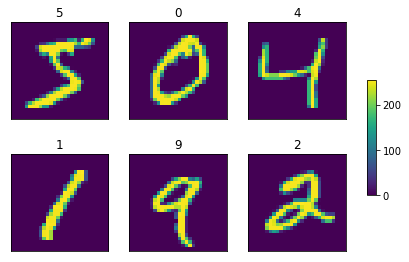

In [9]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    im = plt.imshow(example_data[i][0], interpolation='none', vmin=0, vmax=255)
    plt.title("{}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.02, 0.4])
fig.colorbar(im, cax=cbar_ax)
fig.savefig(folder_fig.joinpath(f'MNIST_samples.pdf'), format='pdf', dpi=300)

## Map to Current (No noise):

Samples shape: torch.Size([300, 784])


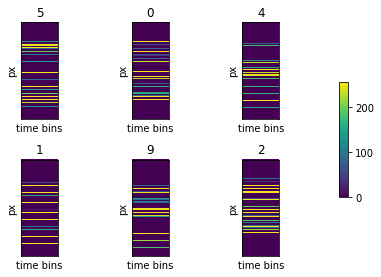

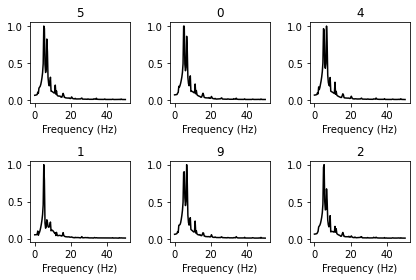

In [10]:
add_noise = False

# Transformation:
stim_len_sec = 3
dt_sec = 1e-2
v_max = 0.2
batch_size_train = 10
batch_size_test = 10

# Train:
train_loader = DataLoader(MNIST(root='data', train=True, download=True, 
                                transform=transforms.Compose([transforms.PILToTensor(), 
                                                              ToCurrent(stim_len_sec, dt_sec, v_max, add_noise=add_noise)])), 
                          batch_size=batch_size_train, 
                          shuffle=shuffle_data, 
                          generator=generator)

# Test:
test_loader = DataLoader(MNIST(root='data', train=False, download=True, 
                               transform=transforms.Compose([transforms.PILToTensor(),
                                                             ToCurrent(stim_len_sec, dt_sec, v_max, add_noise=add_noise)])),
                         batch_size=batch_size_test, 
                         shuffle=shuffle_data, 
                         generator=generator)
# Print samples size:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print('Samples shape:', example_data[0].shape)

# Plot:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    im=plt.imshow(torch.transpose(example_data[i], 1,0), interpolation='none', vmin=0, vmax=255+v_max)    
    plt.title("{}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('time bins')
    plt.ylabel('px')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.02, 0.4])
fig.colorbar(im, cax=cbar_ax)
fig.savefig(folder_fig.joinpath(f'MNIST_samples_post_proc.pdf'), format='pdf', dpi=300)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    xf, y = get_fft(example_data[i], dt_sec)
    plt.plot(xf, y, c='k')
    plt.title("{}".format(example_targets[i]))
    plt.xlabel('Frequency (Hz)')
fig.savefig(folder_fig.joinpath(f'MNIST_samples_post_proc_spectrum.pdf'), format='pdf', dpi=300)

## Map to Current (Add uniform noise):

Samples shape: torch.Size([300, 784])


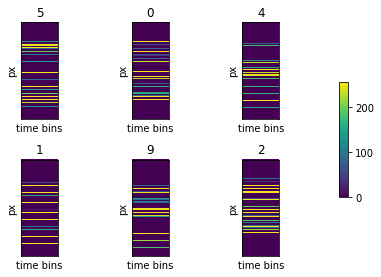

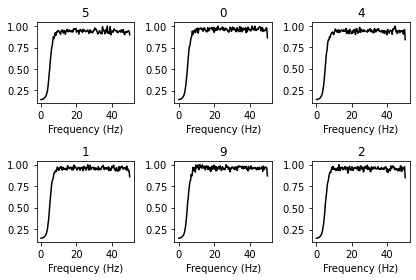

In [11]:
add_noise = True

# Transformation:
stim_len_sec = 3
dt_sec = 1e-2
v_max = 0.2
batch_size_train = 10
batch_size_test = 10

# Train:
train_loader = DataLoader(MNIST(root='data', train=True, download=True, 
                                transform=transforms.Compose([transforms.PILToTensor(), 
                                                              ToCurrent(stim_len_sec, dt_sec, v_max, add_noise=add_noise)])), 
                          batch_size=batch_size_train, 
                          shuffle=shuffle_data, 
                          generator=generator)

# Test:
test_loader = DataLoader(MNIST(root='data', train=False, download=True, 
                               transform=transforms.Compose([transforms.PILToTensor(),
                                                             ToCurrent(stim_len_sec, dt_sec, v_max, add_noise=add_noise)])),
                         batch_size=batch_size_test, 
                         shuffle=shuffle_data, 
                         generator=generator)
# Print samples size:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print('Samples shape:', example_data[0].shape)

# Plot:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    im=plt.imshow(torch.transpose(example_data[i], 1,0), interpolation='none', vmin=0, vmax=255+v_max)    
    plt.title("{}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('time bins')
    plt.ylabel('px')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.02, 0.4])
fig.colorbar(im, cax=cbar_ax)
fig.savefig(folder_fig.joinpath(f'MNIST_samples_post_proc_with_noise.pdf'), format='pdf', dpi=300)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    xf, y = get_fft(example_data[i], dt_sec)
    plt.plot(xf, y, c='k')
    plt.title("{}".format(example_targets[i]))
    plt.xlabel('Frequency (Hz)')
fig.savefig(folder_fig.joinpath(f'MNIST_samples_post_proc_spectrum_with_noise.pdf'), format='pdf', dpi=300)

## Load dataset:

In [12]:
stim_len_sec = 3
dt_sec = 1e-2
batch_size = 100
train_dl, test_dl = load_MNIST(batch_size=batch_size, stim_len_sec=stim_len_sec, dt_sec=dt_sec, v_max=v_max, add_noise=True, return_fft=True)

N samples training: 60000
N samples test: 10000


In [13]:
# Check sample sizes:
examples = enumerate(train_dl)
batch_idx, (example_data, example_targets) = next(examples)
shape = example_data.shape

assert(shape[0]==batch_size)
n_time_steps = int(stim_len_sec/dt_sec)
assert(shape[1]==len(rfftfreq(n_time_steps, dt_sec)))
assert(shape[2]==n_pixels**2)
# shape[0]: batch_size
# shape[1]: freq
# shape[2]: px

In [15]:
from utils_dataset import extract_interval

In [23]:
center = 10
span = 10
sample_size = 10


# Extract parameters:
examples = enumerate(train_dl)
batch_idx, (example_data, example_targets) = next(examples)
print('Samples shape:', example_data.shape)

n_ch = example_data.shape[-1]
xf = rfftfreq(n_time_steps, dt_sec)

classifier = nn.Sequential(nn.Linear(n_ch, len(np.unique(train_dl.dataset.targets))),).to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
epochs = tqdm.trange(100, desc=f"Classifier",leave=False,position=1)

if epochs is None:
    epochs = trange(epochs, desc=f"Classifier")
else:
    epochs.reset()
    
batches = tqdm.tqdm(train_dl, desc="Epoch", disable=True)
loss = nn.CrossEntropyLoss()
loss_coll = []
acc_coll = []

for batch_idx, (data, targets) in enumerate(train_dl):

    data_f = extract_interval(data, xf, sample_size, center, span)
        
    break

Samples shape: torch.Size([100, 151, 784])



Classifier:   0%|                                                                                                                                                                                                                                                 | 0/100 [00:00<?, ?it/s]
                                                                                                                                                                                                                                                                                          
Classifier:   0%|                                                                                                                                                                                                                                                 | 0/100 [00:00<?, ?it/s]

In [26]:
data_f.shape

torch.Size([100, 10])

In [27]:
data_f.shape

torch.Size([100, 10])

In [38]:
data_f[:,f,:].shape

IndexError: too many indices for tensor of dimension 2

## Preprocessing

In [34]:
centers = np.linspace(10, 20, 10)
spans=np.linspace(10, 20, 10)
name='frequency'
sample_size = 10

matrix = {}

df_acc = {'center': [], 'span': [], 'acc': []}
matrix[0] = np.zeros((len(centers),len(spans)))
sweep = tqdm.tqdm(total=len(centers)*len(spans), desc=f"{name[0].upper() + name[1:]} Sweeping",position=0,leave=True)
epochs = tqdm.trange(100, desc=f"Classifier",leave=False,position=1)
for c_idx,center in enumerate(centers):
    for s_idx,span in enumerate(spans):
        acc, list_acc_last_epoch = classify_fft(center, span, train_dl, test_dl, epochs,sample_size=sample_size)
        matrix[0][c_idx,s_idx] = acc
        
        df_acc['center'].extend([center]*len(list_acc_last_epoch))
        df_acc['span'].extend([span]*len(list_acc_last_epoch))
        df_acc['acc'].extend(list_acc_last_epoch)
        
        sweep.update()

Frequency Sweeping:   0%|                                                                                                    | 0/100 [00:07<?, ?it/s]

Classifier:   0%|                                                                                                            | 0/100 [00:00<?, ?it/s]
                                                                                                                                                     

NameError: name 'labels' is not defined

In [36]:
center = 10
span = 10

examples = enumerate(train_dl)
batch_idx, (example_data, example_targets) = next(examples)
print('Samples shape:', example_data.shape)

n_ch = example_data.shape[-1]
xf = rfftfreq(n_time_steps, dt)

# classifier = nn.Sequential(nn.Linear(n_ch, len(np.unique(train_dl.dataset.targets))),).to(device)
# optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
# if epochs is None:
#     epochs = trange(100, desc=f"Classifier")
# else:
#     epochs.reset()
# batches = tqdm.tqdm(train_dl, desc="Epoch", disable=True)
# loss = nn.CrossEntropyLoss()
# loss_coll = []
# acc_coll = []

# for batch_idx, (data, targets) in enumerate():

#     data_f = extract_interval(data,xf,sample_size,center,span)

Samples shape: torch.Size([100, 151, 784])


NameError: name 'n_time_steps' is not defined

In [14]:
import pandas as pd

df_acc = pd.DataFrame(df_acc)

In [15]:
df_acc

,center,span,acc
0,10.0,10.000000,0.10
1,10.0,10.000000,0.18
2,10.0,10.000000,0.12
3,10.0,10.000000,0.05
4,10.0,11.111111,0.11
...,...,...,...
395,20.0,18.888889,0.09
396,20.0,20.000000,0.09
397,20.0,20.000000,0.14
398,20.0,20.000000,0.11


<AxesSubplot:xlabel='center', ylabel='acc'>

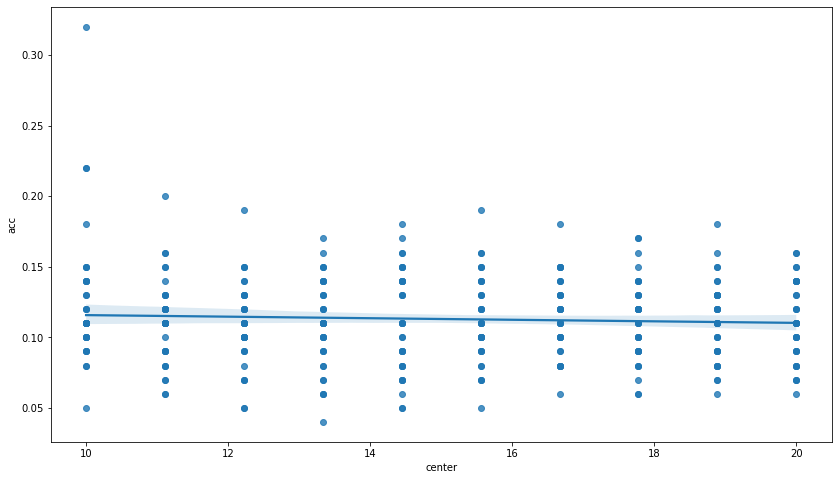

In [16]:
plt.figure(figsize=(14,8))
sns.regplot(x=df_acc["center"], y=df_acc["acc"])

In [18]:
df_acc.corr(method ='pearson')

,center,span,acc
center,1.000000e+00,-7.516896e-16,-0.056711
span,-7.516896e-16,1.000000e+00,0.040387
acc,-5.671115e-02,4.038734e-02,1.000000


/tmp/ipykernel_111938/1818450471.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


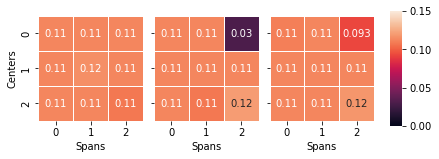

In [42]:
import seaborn as sns

fig, axs = plt.subplots(1,len(matrix.keys()), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in matrix.keys():
    sns.heatmap(matrix[i], annot=True, ax=axs[i], 
                linewidth=.5,
                cbar=i == 0,
                vmin=0, vmax=0.15,
                square=True,
                cbar_ax=None if i else cbar_ax)
    axs[i].set_xlabel('Spans')
axs[0].set_ylabel('Centers')
fig.tight_layout(rect=[0, 0, .9, 1])

In [ ]:
# Cehck if 

In [43]:
# Load data input to classifier:

In [45]:
data = np.load('./data/dataset_analysis/data_fft_10.0_10.0.npy')

In [46]:
data.shape

(2000, 10)

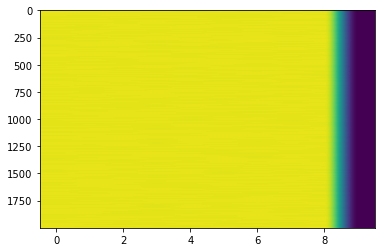

In [49]:
plt.imshow(data, aspect='auto')

In [50]:
data = np.load('./data/dataset_analysis/data_fft_10.0_15.0.npy')

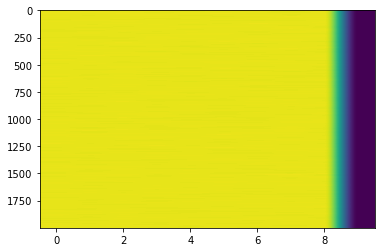

In [51]:
plt.imshow(data, aspect='auto')

In [54]:
data = np.load('./data/dataset_analysis/data_fft_20.0_10.0.npy')

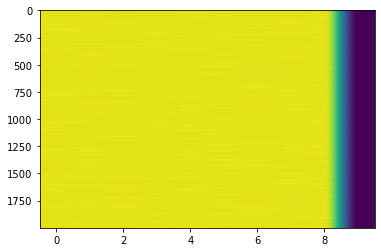

In [55]:
plt.imshow(data, aspect='auto')